# Downloading data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing data for training

In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ==== Paths ====
train_dir = '/content/drive/MyDrive/VGG_Data/train'
test_dir  = '/content/drive/MyDrive/VGG_Data/test'

# ==== Parameters ====
img_size    = (256, 256)
batch_size  = 16
seed        = 123
n_splits    = 5

# ==== Utility: Build tf.data Dataset from file paths and labels ====
def make_dataset(file_paths, labels, shuffle=True, tag=''):
    print(f"📦 Loading {len(file_paths)} images for {tag}...")

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_paths), seed=seed)

    def _load(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image.set_shape([None, None, 3])  # Prevent shape-related crashes
        image = tf.image.resize(image, img_size)
        image = preprocess_input(image)
        return image, label

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    print(f"✅ Successfully prepared dataset with {len(file_paths)} images for {tag}.")
    return ds


# ==== Gather file paths & labels for train ====
file_paths, labels = [], []
class_names = sorted(os.listdir(train_dir))
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    for fname in os.listdir(class_path):
        file_paths.append(os.path.join(class_path, fname))
        labels.append(idx)
file_paths = np.array(file_paths)
labels     = np.array(labels)

In [5]:
# ==== K-Fold Cross-Validation ====
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(file_paths, labels), 1):
    print(f"\n===== Fold {fold}/{n_splits} =====")
    train_ds = make_dataset(file_paths[train_idx], labels[train_idx], shuffle=True)
    val_ds   = make_dataset(file_paths[val_idx],   labels[val_idx],   shuffle=False)



===== Fold 1/5 =====
📦 Loading 2878 images for ...
✅ Successfully prepared dataset with 2878 images for .
📦 Loading 720 images for ...
✅ Successfully prepared dataset with 720 images for .

===== Fold 2/5 =====
📦 Loading 2878 images for ...
✅ Successfully prepared dataset with 2878 images for .
📦 Loading 720 images for ...
✅ Successfully prepared dataset with 720 images for .

===== Fold 3/5 =====
📦 Loading 2878 images for ...
✅ Successfully prepared dataset with 2878 images for .
📦 Loading 720 images for ...
✅ Successfully prepared dataset with 720 images for .

===== Fold 4/5 =====
📦 Loading 2879 images for ...
✅ Successfully prepared dataset with 2879 images for .
📦 Loading 719 images for ...
✅ Successfully prepared dataset with 719 images for .

===== Fold 5/5 =====
📦 Loading 2879 images for ...
✅ Successfully prepared dataset with 2879 images for .
📦 Loading 719 images for ...
✅ Successfully prepared dataset with 719 images for .


In [ ]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=seed,
    color_mode='rgb',
    image_size=img_size,
    batch_size=train_batch_size
)

# ✅ Print class names before prefetch
print("Class names:", train_ds.class_names)

# Then continue with prefetching
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)


Found 3200 files belonging to 2 classes.
Class names: ['defect', 'normal']


In [ ]:
import os
from PIL import Image

def verify_exact_dimensions(directory, expected_size=(512, 512)):
    wrong_sized_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')):
                path = os.path.join(root, file)
                try:
                    with Image.open(path) as img:
                        width, height = img.size
                        if (width, height) != expected_size:
                            print(f"{file} → {width}x{height}")
                            wrong_sized_images.append((file, (width, height)))
                except Exception as e:
                    print(f"Error reading {path}: {e}")
    return wrong_sized_images

train_dir = '/content/drive/MyDrive/VGG/train'
verify_exact_dimensions(train_dir)


Yellow cloth_525bacd7798141238e33144ee492c29d.png → 513x512
Yellow cloth_1c086f504b67469fa0ff7a90494f1909.png → 513x512
Yellow cloth_926b1e0efd504ed4ac9cbbdfd7c3f35f.png → 513x512
Yellow cloth_051.png → 513x512
Yellow cloth_d9397b2f973740e085ff5d7faf719d2e.png → 513x512


[('Yellow cloth_525bacd7798141238e33144ee492c29d.png', (513, 512)),
 ('Yellow cloth_1c086f504b67469fa0ff7a90494f1909.png', (513, 512)),
 ('Yellow cloth_926b1e0efd504ed4ac9cbbdfd7c3f35f.png', (513, 512)),
 ('Yellow cloth_051.png', (513, 512)),
 ('Yellow cloth_d9397b2f973740e085ff5d7faf719d2e.png', (513, 512))]

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(256, 512, 512, 3)
(256,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preparing model for training

In [6]:

num_classes=2

In [13]:
from tensorflow.keras.utils import get_custom_objects
# ==== Model Components ====
def se_block(inputs, ratio=8):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([inputs, se])

# Token reduction: simple patch merging
class PatchMerging(layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool = layers.AveragePooling2D(pool_size)
    def call(self, x):
        return self.pool(x)


def transformer_encoder(inputs, num_heads=2, ff_dim=256, dropout_rate=0.1):
    x1 = layers.LayerNormalization()(inputs)
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1]//num_heads
    )(x1, x1)
    x2 = layers.Add()([inputs, attn_output])
    x3 = layers.LayerNormalization()(x2)
    ffn = layers.Dense(ff_dim, activation='gelu')(x3)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    return layers.Add()([x2, ffn])

# ==== Build Updated Hybrid Model ====
def build_hybrid_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)
    backbone = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')

    # Multi-scale features
    feat_small = backbone.get_layer('block3a_expand_activation').output  # 32x32x32
    feat_large = backbone.get_layer('block4a_expand_activation').output  # 16x16x144

    # Small path: separable 1x1 conv + pooling + SE
    xB = layers.SeparableConv2D(96, 1, activation='swish')(feat_small)
    xB = PatchMerging(pool_size=2)(xB)                     # -> 16x16x96
    xB = se_block(xB)

    # Large path: SE
    xA = se_block(feat_large)                              # 16x16x144

    # Fuse features
    x = layers.Concatenate()([xA, xB])                     # 16x16x(144+96)
    x = layers.SeparableConv2D(192, 1, activation='swish')(x)

    # Further spatial reduction to reduce tokens
    x = PatchMerging(pool_size=2)(x)                       # -> 8x8x192

    # Flatten + positional embeddings
    h, w, c = x.shape[1], x.shape[2], x.shape[3]
    x_flat = layers.Reshape((h*w, c))(x)
    pos_embed = tf.Variable(tf.random.normal([1, h*w, c]), trainable=True)
    x_flat = layers.Add()([x_flat, pos_embed])

    # Transformer layers
    for _ in range(2):
        x_flat = transformer_encoder(x_flat, num_heads=2, ff_dim=256)

    # Reshape back to spatial
    x = layers.Reshape((h, w, c))(x_flat)

    # Classifier head\#
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    return models.Model(inputs, outputs)

    # 2) Register them globally:
get_custom_objects().update({
    'PatchMerging': PatchMerging,
    'se_block': se_block,
    'transformer_encoder': transformer_encoder
})

In [10]:
model = build_hybrid_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 683,300 (2.61 MB)

 Trainable params: 679,901 (2.59 MB)

 Non-trainable params: 3,399 (13.28 KB)

In [16]:
from tensorflow.keras import backend as K

for fold, (train_idx, val_idx) in enumerate(skf.split(file_paths, labels), 1):
    print(f"\n===== Fold {fold}/{n_splits} =====")

    # 1) Clear any leftover model/graph state
    K.clear_session()

    # 2) Build & compile fresh
    model = build_hybrid_model()
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # 3) Instantiate callbacks *inside* the loop so fold is captured
    callbacks = [
        ModelCheckpoint(
            filepath=f'best_fold{fold}.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            patience=3,
            factor=0.5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # 4) Prepare this fold’s data
    train_ds = make_dataset(
        file_paths[train_idx],
        labels[train_idx],
        shuffle=True,
        tag=f'Fold {fold} – Train'
    )
    val_ds = make_dataset(
        file_paths[val_idx],
        labels[val_idx],
        shuffle=False,
        tag=f'Fold {fold} – Val'
    )

    # 5) Fit
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )



===== Fold 1/5 =====
📦 Loading 2878 images for Fold 1 – Train...
✅ Successfully prepared dataset with 2878 images for Fold 1 – Train.
📦 Loading 720 images for Fold 1 – Val...
✅ Successfully prepared dataset with 720 images for Fold 1 – Val.
Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5643 - loss: 0.6897
Epoch 1: val_loss improved from inf to 0.52839, saving model to best_fold1.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 94s 311ms/step - accuracy: 0.5647 - loss: 0.6894 - val_accuracy: 0.7361 - val_loss: 0.5284 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7572 - loss: 0.5097
Epoch 2: val_loss improved from 0.52839 to 0.27497, saving model to best_fold1.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.7574 - loss: 0.5094 - val_accuracy: 0.8931 - val_loss: 0.2750 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8793 - loss: 0.3123
Epoch 3: val_loss improved from 0.27497 to 0.22169, saving model to best_fold1.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.8794 - loss: 0.3122 - val_accuracy: 0.9097 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9301 - loss: 0.2054
Epoch 4: val_loss improved from 0.22169 to 0.15365, saving model to best_fold1.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.9301 - loss: 0.2053 - val_accuracy: 0.9444 - val_loss: 0.1536 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9585 - loss: 0.1204
Epoch 5: val_loss did not improve from 0.15365
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.9585 - loss: 0.1204 - val_accuracy: 0.8667 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9475 - loss: 0.1373
Epoch 6: val_loss improved from 0.15365 to 0.09958, saving model to best_fold1.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 45s 187ms/step - accuracy: 0.9476 - loss: 0.1373 - val_accuracy: 0.9611 - val_loss: 0.0996 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9690 - loss: 0.0936
Epoch 7: val_loss improved from 0.09958 to 0.07001, saving model to best_fold1.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.9690 - loss: 0.0936 - val_accuracy: 0.9722 - val_loss: 0.0700 - learning_rate: 0.0010
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9721 - loss: 0.0863
Epoch 8: val_loss did not improve from 0.07001
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.9720 - loss: 0.0863 - val_accuracy: 0.9653 - val_loss: 0.0940 - learning_rate: 0.0010
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9699 - loss: 0.0928
Epoch 9: val_loss did not improve from 0.07001
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.9700 - loss: 0.0927 - val_accuracy: 0.9736 - val_loss: 0.0754 - learning_rate: 0.0010
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9817 - loss: 0.0586
Epoch 10: val_loss improved from 0.07001 to 0.06211, saving model to best_fold1.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 0.9817 - loss: 0.0588 - val_accuracy: 0.9819 - val_loss: 0.0621 - learning_rate: 0.0010
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9771 - loss: 0.0709
Epoch 11: val_loss did not improve from 0.06211
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9771 - loss: 0.0709 - val_accuracy: 0.9722 - val_loss: 0.0790 - learning_rate: 0.0010
Epoch 12/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9853 - loss: 0.0505
Epoch 12: val_loss did not improve from 0.06211
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.9853 - loss: 0.0505 - val_accuracy: 0.9764 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 13/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9871 - loss: 0.0457
Epoch 13: val_loss did not improve from 0.06211

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.9871 - loss: 0.0457 -

180/180 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.9952 - loss: 0.0191 - val_accuracy: 0.9847 - val_loss: 0.0464 - learning_rate: 5.0000e-04
Epoch 15/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9913 - loss: 0.0280
Epoch 15: val_loss did not improve from 0.04644
180/180 ━━━━━━━━━━━━━━━━━━━━ 46s 189ms/step - accuracy: 0.9913 - loss: 0.0280 - val_accuracy: 0.9903 - val_loss: 0.0470 - learning_rate: 5.0000e-04
Epoch 16/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9912 - loss: 0.0199
Epoch 16: val_loss did not improve from 0.04644
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - accuracy: 0.9912 - loss: 0.0199 - val_accuracy: 0.9806 - val_loss: 0.0614 - learning_rate: 5.0000e-04
Epoch 17/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9943 - loss: 0.0199
Epoch 17: val_loss did not improve from 0.04644

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
180/180 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - accuracy: 0.9942 - lo

180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 283ms/step - accuracy: 0.5387 - loss: 0.6964 - val_accuracy: 0.6667 - val_loss: 0.7330 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7905 - loss: 0.4769
Epoch 2: val_loss improved from 0.73295 to 0.37739, saving model to best_fold2.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy: 0.7907 - loss: 0.4764 - val_accuracy: 0.8917 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9123 - loss: 0.2530
Epoch 3: val_loss improved from 0.37739 to 0.10412, saving model to best_fold2.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9124 - loss: 0.2527 - val_accuracy: 0.9667 - val_loss: 0.1041 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9464 - loss: 0.1636
Epoch 4: val_loss did not improve from 0.10412
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.9465 - loss: 0.1634 - val_accuracy: 0.9611 - val_loss: 0.1212 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9737 - loss: 0.1042
Epoch 5: val_loss did not improve from 0.10412
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.9737 - loss: 0.1042 - val_accuracy: 0.9403 - val_loss: 0.1443 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9767 - loss: 0.0754
Epoch 6: val_loss improved from 0.10412 to 0.07839, saving model to best_fold2.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9767 - loss: 0.0755 - val_accuracy: 0.9778 - val_loss: 0.0784 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9735 - loss: 0.0851
Epoch 7: val_loss did not improve from 0.07839
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.9735 - loss: 0.0851 - val_accuracy: 0.9556 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9713 - loss: 0.0904
Epoch 8: val_loss did not improve from 0.07839
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.9713 - loss: 0.0904 - val_accuracy: 0.9764 - val_loss: 0.1040 - learning_rate: 0.0010
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9779 - loss: 0.0860
Epoch 9: val_loss did not improve from 0.07839

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9779 - loss: 0.0860 - val_ac

180/180 ━━━━━━━━━━━━━━━━━━━━ 46s 189ms/step - accuracy: 0.9883 - loss: 0.0605 - val_accuracy: 0.9847 - val_loss: 0.0526 - learning_rate: 5.0000e-04
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9926 - loss: 0.0247
Epoch 11: val_loss improved from 0.05260 to 0.05220, saving model to best_fold2.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.9926 - loss: 0.0247 - val_accuracy: 0.9889 - val_loss: 0.0522 - learning_rate: 5.0000e-04
Epoch 12/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9906 - loss: 0.0289
Epoch 12: val_loss did not improve from 0.05220
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.9906 - loss: 0.0289 - val_accuracy: 0.9875 - val_loss: 0.0618 - learning_rate: 5.0000e-04
Epoch 13/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9938 - loss: 0.0222
Epoch 13: val_loss did not improve from 0.05220
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9938 - loss: 0.0223 - val_accuracy: 0.9806 - val_loss: 0.0531 - learning_rate: 5.0000e-04
Epoch 14/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9870 - loss: 0.0334
Epoch 14: val_loss did not improve from 0.05220

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9870 - lo

180/180 ━━━━━━━━━━━━━━━━━━━━ 85s 270ms/step - accuracy: 0.5501 - loss: 0.6800 - val_accuracy: 0.8278 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7933 - loss: 0.4509
Epoch 2: val_loss improved from 0.40554 to 0.19746, saving model to best_fold3.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 162ms/step - accuracy: 0.7935 - loss: 0.4505 - val_accuracy: 0.9292 - val_loss: 0.1975 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9210 - loss: 0.2285
Epoch 3: val_loss improved from 0.19746 to 0.14438, saving model to best_fold3.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9211 - loss: 0.2285 - val_accuracy: 0.9389 - val_loss: 0.1444 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9519 - loss: 0.1438
Epoch 4: val_loss improved from 0.14438 to 0.09612, saving model to best_fold3.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 192ms/step - accuracy: 0.9519 - loss: 0.1438 - val_accuracy: 0.9736 - val_loss: 0.0961 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9673 - loss: 0.0932
Epoch 5: val_loss improved from 0.09612 to 0.08837, saving model to best_fold3.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9673 - loss: 0.0932 - val_accuracy: 0.9750 - val_loss: 0.0884 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9741 - loss: 0.0740
Epoch 6: val_loss did not improve from 0.08837
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.9741 - loss: 0.0741 - val_accuracy: 0.9028 - val_loss: 0.2578 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9618 - loss: 0.1149
Epoch 7: val_loss did not improve from 0.08837
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.9618 - loss: 0.1148 - val_accuracy: 0.9361 - val_loss: 0.2194 - learning_rate: 0.0010
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9723 - loss: 0.0920
Epoch 8: val_loss improved from 0.08837 to 0.08255, saving model to best_fold3.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.9723 - loss: 0.0920 - val_accuracy: 0.9750 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9781 - loss: 0.0751
Epoch 9: val_loss improved from 0.08255 to 0.07740, saving model to best_fold3.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 46s 196ms/step - accuracy: 0.9781 - loss: 0.0752 - val_accuracy: 0.9764 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9829 - loss: 0.0540
Epoch 10: val_loss improved from 0.07740 to 0.06196, saving model to best_fold3.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.9829 - loss: 0.0540 - val_accuracy: 0.9806 - val_loss: 0.0620 - learning_rate: 0.0010
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9770 - loss: 0.0730
Epoch 11: val_loss improved from 0.06196 to 0.04548, saving model to best_fold3.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.9770 - loss: 0.0729 - val_accuracy: 0.9861 - val_loss: 0.0455 - learning_rate: 0.0010
Epoch 12/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9909 - loss: 0.0362
Epoch 12: val_loss did not improve from 0.04548
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.9909 - loss: 0.0362 - val_accuracy: 0.9764 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 13/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9893 - loss: 0.0344
Epoch 13: val_loss did not improve from 0.04548
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.9893 - loss: 0.0344 - val_accuracy: 0.9792 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 14/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9821 - loss: 0.0525
Epoch 14: val_loss did not improve from 0.04548

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9821 - loss: 0.0525 -

180/180 ━━━━━━━━━━━━━━━━━━━━ 89s 285ms/step - accuracy: 0.5636 - loss: 0.6938 - val_accuracy: 0.7608 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8021 - loss: 0.4473
Epoch 2: val_loss improved from 0.49872 to 0.33313, saving model to best_fold4.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 192ms/step - accuracy: 0.8023 - loss: 0.4470 - val_accuracy: 0.8637 - val_loss: 0.3331 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9097 - loss: 0.2478
Epoch 3: val_loss improved from 0.33313 to 0.17481, saving model to best_fold4.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9098 - loss: 0.2476 - val_accuracy: 0.9305 - val_loss: 0.1748 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9386 - loss: 0.1640
Epoch 4: val_loss did not improve from 0.17481
180/180 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - accuracy: 0.9387 - loss: 0.1639 - val_accuracy: 0.9485 - val_loss: 0.1993 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9614 - loss: 0.1232
Epoch 5: val_loss improved from 0.17481 to 0.12785, saving model to best_fold4.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.9614 - loss: 0.1231 - val_accuracy: 0.9680 - val_loss: 0.1278 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9810 - loss: 0.0542
Epoch 6: val_loss improved from 0.12785 to 0.06482, saving model to best_fold4.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.9809 - loss: 0.0542 - val_accuracy: 0.9805 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9704 - loss: 0.0824
Epoch 7: val_loss did not improve from 0.06482
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.9705 - loss: 0.0824 - val_accuracy: 0.9666 - val_loss: 0.1456 - learning_rate: 0.0010
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9740 - loss: 0.1129
Epoch 8: val_loss did not improve from 0.06482
180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.9740 - loss: 0.1128 - val_accuracy: 0.9638 - val_loss: 0.1205 - learning_rate: 0.0010
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9829 - loss: 0.0487
Epoch 9: val_loss did not improve from 0.06482

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 162ms/step - accuracy: 0.9829 - loss: 0.0488 - val_ac

180/180 ━━━━━━━━━━━━━━━━━━━━ 101s 355ms/step - accuracy: 0.5750 - loss: 0.6892 - val_accuracy: 0.8178 - val_loss: 0.4027 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8076 - loss: 0.4203
Epoch 2: val_loss improved from 0.40267 to 0.26660, saving model to best_fold5.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 170ms/step - accuracy: 0.8078 - loss: 0.4200 - val_accuracy: 0.8860 - val_loss: 0.2666 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9144 - loss: 0.2366
Epoch 3: val_loss improved from 0.26660 to 0.09307, saving model to best_fold5.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.9145 - loss: 0.2365 - val_accuracy: 0.9722 - val_loss: 0.0931 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9519 - loss: 0.1313
Epoch 4: val_loss did not improve from 0.09307
180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.9519 - loss: 0.1312 - val_accuracy: 0.9513 - val_loss: 0.1001 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9692 - loss: 0.1033
Epoch 5: val_loss did not improve from 0.09307
180/180 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.9692 - loss: 0.1033 - val_accuracy: 0.9666 - val_loss: 0.1116 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9612 - loss: 0.1053
Epoch 6: val_loss did not improve from 0.09307

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.9612 - loss: 0.1053 - val_ac

In [18]:
import os
import numpy as np

# === Paths ===
test_dir = '/content/drive/MyDrive/VGG/test'
class_names = sorted(os.listdir(test_dir))  # ['defect', 'normal'] assumed
class_to_index = {name: idx for idx, name in enumerate(class_names)}

# === Get image paths and labels ===
test_paths = []
test_labels = []

for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif')):
            test_paths.append(os.path.join(class_path, fname))
            test_labels.append(class_to_index[class_name])

test_paths = np.array(test_paths)
test_labels = np.array(test_labels)


In [19]:
test_ds = make_dataset(test_paths, test_labels, shuffle=False, tag='Test')

all_test_acc = []
all_test_loss = []

for fold in range(1, 6):
    print(f"\n🔍 Evaluating best_fold{fold}.h5")

    model = build_hybrid_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.load_weights(f'best_fold{fold}.h5')

    loss, acc = model.evaluate(test_ds, verbose=0)
    all_test_loss.append(loss)
    all_test_acc.append(acc)

    print(f"✅ Fold {fold}: Test Accuracy = {acc:.4f}, Test Loss = {loss:.4f}")

# Print average results
mean_acc = np.mean(all_test_acc)
std_acc = np.std(all_test_acc)
mean_loss = np.mean(all_test_loss)
std_loss = np.std(all_test_loss)

print(f"\n📊 Average Test Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"📊 Average Test Loss    : {mean_loss:.4f} ± {std_loss:.4f}")


📦 Loading 402 images for Test...
✅ Successfully prepared dataset with 402 images for Test.

🔍 Evaluating best_fold1.h5
✅ Fold 1: Test Accuracy = 0.9826, Test Loss = 0.0568

🔍 Evaluating best_fold2.h5
✅ Fold 2: Test Accuracy = 0.9826, Test Loss = 0.0502

🔍 Evaluating best_fold3.h5
✅ Fold 3: Test Accuracy = 0.9652, Test Loss = 0.0931

🔍 Evaluating best_fold4.h5
✅ Fold 4: Test Accuracy = 0.9577, Test Loss = 0.1071

🔍 Evaluating best_fold5.h5
✅ Fold 5: Test Accuracy = 0.9577, Test Loss = 0.1402

📊 Average Test Accuracy: 0.9692 ± 0.0113
📊 Average Test Loss    : 0.0895 ± 0.0332


## Start training and validating results

In [ ]:
n_epoch = 100

In [15]:
history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5610 - loss: 0.7085
Epoch 1: val_loss improved from inf to 0.51093, saving model to best_fold5.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1238s 7s/step - accuracy: 0.5614 - loss: 0.7080 - val_accuracy: 0.7274 - val_loss: 0.5109 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7681 - loss: 0.4723
Epoch 2: val_loss improved from 0.51093 to 0.40543, saving model to best_fold5.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - accuracy: 0.7683 - loss: 0.4721 - val_accuracy: 0.8150 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8758 - loss: 0.3268
Epoch 3: val_loss did not improve from 0.40543
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.8759 - loss: 0.3266 - val_accuracy: 0.8331 - val_loss: 0.5904 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9383 - loss: 0.1728
Epoch 4: val_loss did not improve from 0.40543
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.9383 - loss: 0.1728 - val_accuracy: 0.8720 - val_loss: 0.4454 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9649 - loss: 0.1087
Epoch 5: val_loss improved from 0.40543 to 0.38563, saving model to best_fold5.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 47s 191ms/step - accuracy: 0.9649 - loss: 0.1087 - val_accuracy: 0.8414 - val_loss: 0.3856 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9515 - loss: 0.1365
Epoch 6: val_loss improved from 0.38563 to 0.07806, saving model to best_fold5.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step - accuracy: 0.9515 - loss: 0.1363 - val_accuracy: 0.9722 - val_loss: 0.0781 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9794 - loss: 0.0774
Epoch 7: val_loss did not improve from 0.07806
180/180 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.9794 - loss: 0.0774 - val_accuracy: 0.9652 - val_loss: 0.1521 - learning_rate: 0.0010
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9734 - loss: 0.0984
Epoch 8: val_loss did not improve from 0.07806
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.9734 - loss: 0.0983 - val_accuracy: 0.9638 - val_loss: 0.2089 - learning_rate: 0.0010
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9781 - loss: 0.0630
Epoch 9: val_loss did not improve from 0.07806

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.9781 - loss: 0.0630 - val_ac

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5')  # This automatically loads weights and structure


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

print(f"\n📊 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.2%}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.9718 - loss: 0.0876

📊 Test Loss: 0.0650
✅ Test Accuracy: 98.01%


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Reload your best‐saved model (with Dense(1,activation='sigmoid'))
model = load_model('best_model.h5')

# 2) Re‐load the test dataset exactly as before (no prefetch)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=32,            # a reasonable batch size for predict()
    shuffle=False
)

print("Detected class order:", test_ds.class_names)
# should print ['defect', 'normal'] meaning defect→0, normal→1

# 3) Extract y_true
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# 4) Predict probabilities and threshold
y_prob = model.predict(test_ds)            # shape (N,1)
y_pred = (y_prob > 0.5).astype(int).flatten()

# 5) Report
print("\nClassification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=test_ds.class_names,
    zero_division=0,digits =4
))

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Found 402 files belonging to 2 classes.
Detected class order: ['defect', 'normal']
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 686ms/step

Classification Report:

              precision    recall  f1-score   support

      defect     0.9949    0.9653    0.9799       202
      normal     0.9660    0.9950    0.9803       200

    accuracy                         0.9801       402
   macro avg     0.9805    0.9802    0.9801       402
weighted avg     0.9805    0.9801    0.9801       402

Confusion Matrix:
 [[195   7]
 [  1 199]]


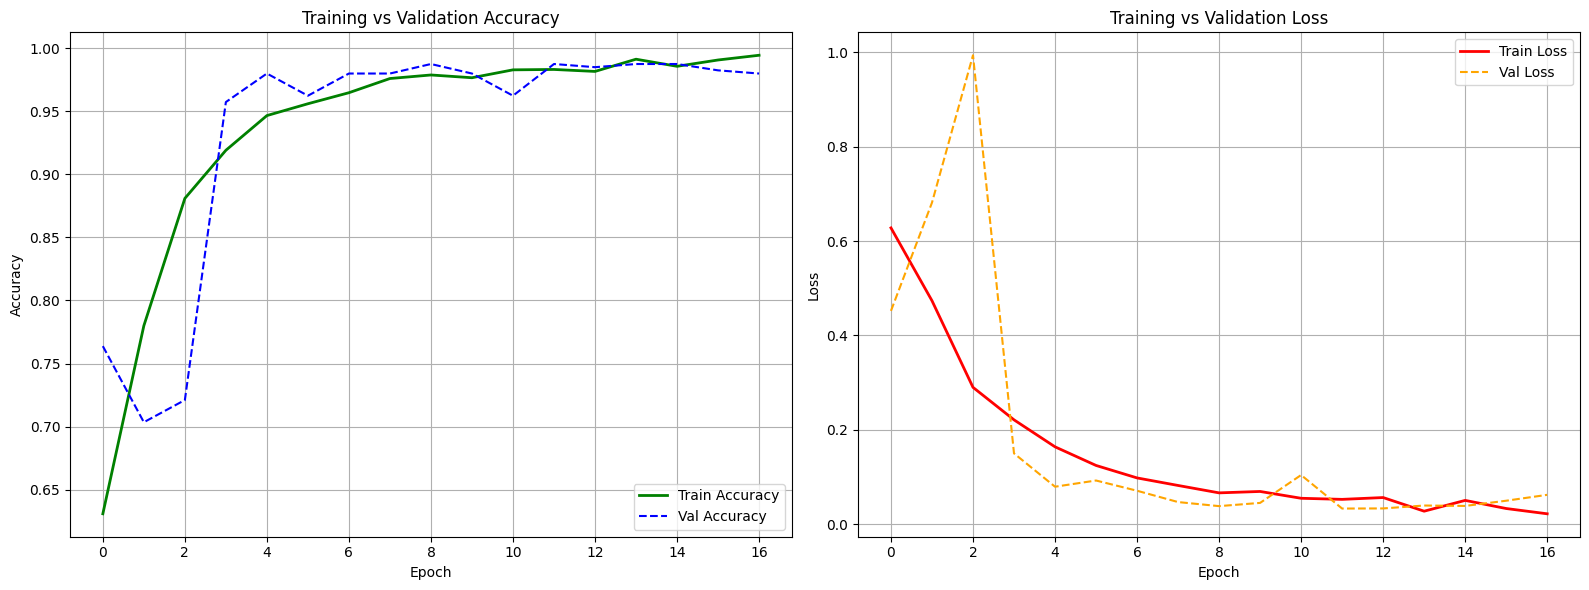

In [ ]:
import matplotlib.pyplot as plt

# ✅ Use actual number of epochs from history
epochs_range = range(len(history.history['accuracy']))

# Extract metrics
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.figure(figsize=(16, 6))

# 🔹 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', color='green', linewidth=2)
plt.plot(epochs_range, val_acc, label='Val Accuracy', color='blue', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# 🔸 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', color='red', linewidth=2)
plt.plot(epochs_range, val_loss, label='Val Loss', color='orange', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


# Testing and Evaluation

In [ ]:
# Make predictions
y_pred = model.predict(val_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert logits to class indices

# Get true labels
y_true = np.array([y.numpy() for x, y in val_ds.unbatch()])
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(label_to_class_mapping.values())
# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step


NameError: name 'np' is not defined

In [ ]:
# Generate classification report
clr = classification_report(y_true, y_pred_classes, target_names=labels)
print(clr)

# Save to a text file
with open("classification_report.txt", "w") as f:
    f.write(clr)

## Live testing

In [ ]:
def get_model_size(path):
        size = os.path.getsize(path)
        if size < 1024:
            return f"{size} bytes"
        elif size < pow(1024,2):
            return f"{round(size/1024, 2)} KB"
        elif size < pow(1024,3):
            return f"{round(size/(pow(1024,2)), 2)} MB"
        elif size < pow(1024,4):
            return f"{round(size/(pow(1024,3)), 2)} GB"

In [ ]:
model = tf.keras.models.load_model(best_model_ckpt_path)
get_model_size(best_model_ckpt_path)

In [ ]:
img_size

In [ ]:
label_to_class_mapping

In [ ]:
def predict_class(img_path):
    img = Image.open(img_path)
    resized_img = img.resize(img_size).convert("RGB")
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    # img = img / 255
    prob = model.predict(img)[0]
    return round(float(np.max(prob)),2), label_to_class_mapping[np.argmax(prob)]

def plot_results(img_path):
    img = Image.open(img_path).convert("RGB")
    resized_img = img.resize(img_size)
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    # img = img / 255
    prob = model.predict(img)
    prob = [round(float(i), 5) for i in prob[0]]

    # Sort probabilities and labels based on probability
    sorted_probs, sorted_labels = zip(*sorted(zip(prob, list(label_to_class_mapping.values())), reverse=False))

    # Create a larger plot
    plt.figure(figsize=(10, 8))

    # Plot the image
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.axis('off')  # Hide axes for the image

    # Plot the probabilities
    plt.subplot(2, 1, 2)
    bars = plt.barh(sorted_labels, sorted_probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.5f')

    plt.tight_layout()  # To avoid overlapping subplots
    plt.show()

In [ ]:
sample_data = test_df.drop_duplicates('Class')
sample_data

In [ ]:
prob,pred = predict_class(sample_data['Image Path'].values[0])
prob,pred

In [ ]:
plot_results(sample_data['Image Path'].values[0])

In [ ]:
prob,pred = predict_class(sample_data['Image Path'].values[1])
prob,pred

In [ ]:
plot_results(sample_data['Image Path'].values[1])

In [ ]:
train_df.head()

In [ ]:
# !rm -rf /content/results_data

In [ ]:
# # Set the threshold for maximum number of images per class
# threshold = 10  # Change this to the desired threshold
# sample_data_path = 'sample_images'
# os.makedirs(sample_data_path, exist_ok=True)

# # Dictionary to keep track of the number of images copied for each class
# class_counts = {}

# # Iterate through each row and save correctly predicted images
# for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
#     img_path = row['Image Path']
#     true_label = row['Class']
#     confidence, pred_label = predict_class(img_path)

#     if pred_label == true_label:
#         # Check if the class has already reached the threshold
#         if class_counts.get(pred_label, 0) >= threshold:
#             continue  # Skip if the threshold is reached

#         class_folder = os.path.join(sample_data_path, pred_label)
#         os.makedirs(class_folder, exist_ok=True)

#         # Copy the image to the respective folder
#         shutil.copy(img_path, class_folder)

#         # Increment the count for the class
#         class_counts[pred_label] = class_counts.get(pred_label, 0) + 1

In [ ]:
# !rm -rf /content/drive/MyDrive/saved_model/

In [ ]:
# !ls

In [ ]:
# !mkdir -p /content/drive/MyDrive/saved_model/
# !mv /content/*best_model.keras /content/drive/MyDrive/saved_model/.
# !mv /content/model.png /content/drive/MyDrive/saved_model/.
# !mv /content/training_log.csv /content/drive/MyDrive/saved_model/.
# !mv /content/sample_images /content/drive/MyDrive/saved_model/.
# !mv /content/classification_report.txt /content/drive/MyDrive/saved_model/.
# !mv /content/label_to_class_mapping.json /content/drive/MyDrive/saved_model/.
# !mv /content/model_summary.txt /content/drive/MyDrive/saved_model/.
# !mv /content/confusion_matrix.png /content/drive/MyDrive/saved_model/.
# !mv /content/results.csv /content/drive/MyDrive/saved_model/.